In [121]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from src.utils import (
    process_data_loader,
    print_metrics_in_latex,
    calculate_metrics,
    get_checkpoint_paths,
    mergekfold_results,
    save_normalized_conf_matrices,
    plot_pred_vs_true,
    get_class_dependent_predictions,
    generate_radar_plots,
)

# Specify the path to your pickle file
file_path = "evaluation_metrics/classification_metrics_list.pkl"
with open(file_path, "rb") as file:
    classification_metrics_list = pickle.load(file)

file_path = "evaluation_metrics/regression_metrics_list.pkl"
with open(file_path, "rb") as file:
    regression_metrics_list = pickle.load(file)

file_path = "evaluation_metrics/collect_classification_results.pkl"
with open(file_path, "rb") as file:
    collect_classification_results = pickle.load(file)

file_path = "evaluation_metrics/collect_regression_results.pkl"
with open(file_path, "rb") as file:
    collect_regression_results = pickle.load(file)

In [122]:
def calculate_kfold_mean_and_std(metrics_list):
    df = pd.DataFrame(metrics_list)
    numeric_cols = df.select_dtypes(include=[float]).columns
    grouped_df = df.groupby(["id", "Model", "Combination"])[numeric_cols]
    mean_df = grouped_df.mean()
    std_df = grouped_df.std()
    mean_df.reset_index(inplace=True)
    mean_df.drop(columns="id", inplace=True)
    std_df.reset_index(inplace=True)
    std_df.drop(columns="id", inplace=True)
    return mean_df, std_df


# Calculate mean and std from metric using k-folds
class_mean, class_std = calculate_kfold_mean_and_std(classification_metrics_list)
reg_mean, reg_std = calculate_kfold_mean_and_std(regression_metrics_list)

In [123]:
# Prepare raw results
merged_classification = mergekfold_results(collect_classification_results)
merged_regression = mergekfold_results(collect_regression_results)

### Leaderboard for metrics 

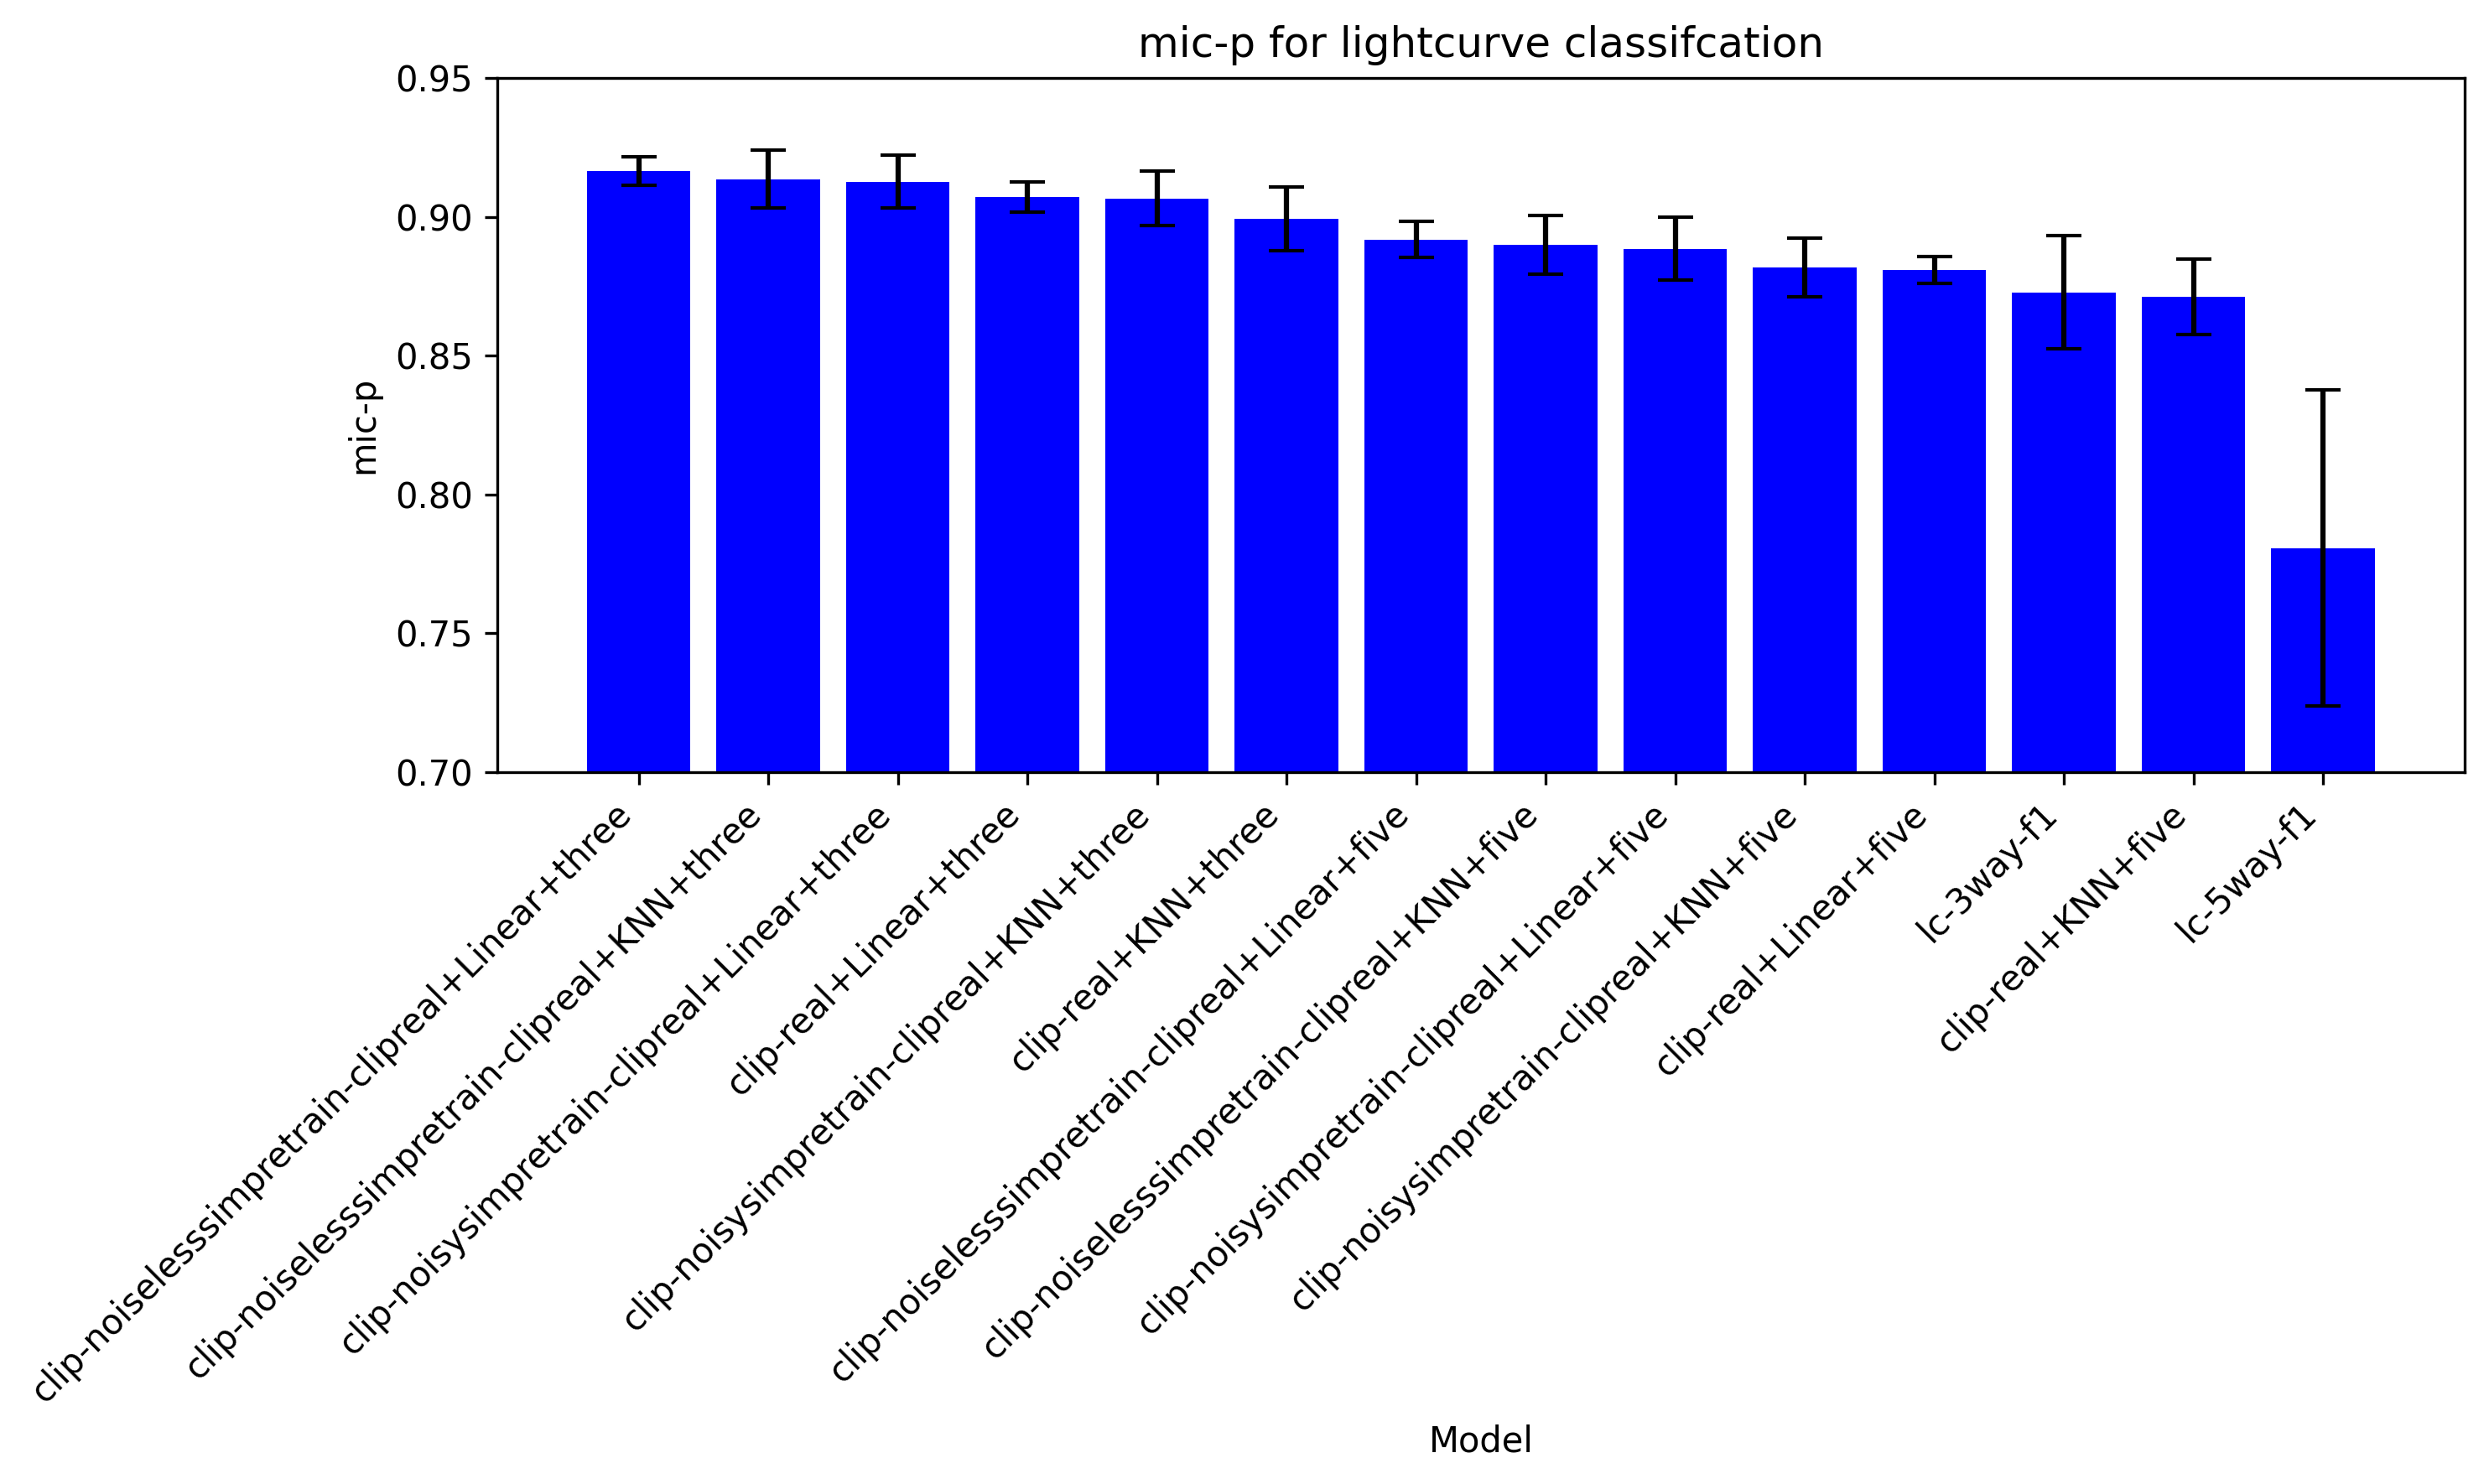

In [124]:
# Leaderboard in different metrics for classifications
# ========================
variable_name = "mic-p"  # Choose from ['mic-f1', 'mic-p', 'mic-r', 'mic-acc', 'mac-f1', 'mac-p', 'mac-r', 'mac-acc']
modality = "lightcurve"
# ========================

lc_class_mean = class_mean[
    class_mean["Combination"] == modality
]  # .drop(columns=dropcols)
lc_class_std = class_std[
    class_std["Combination"] == modality
]  # .drop(columns=dropcols)
lc_class_mean = lc_class_mean.sort_values(by=variable_name, ascending=False)
lc_class_std = lc_class_std.loc[lc_class_mean.index]
plt.figure(figsize=(10, 6), dpi=300)
plt.bar(
    lc_class_mean["Model"],
    lc_class_mean[variable_name],
    yerr=lc_class_std[variable_name],
    capsize=5,
    color="blue",
)
plt.ylim([0.7, 0.95])
plt.xlabel("Model")
plt.ylabel(variable_name)
plt.title(f"{variable_name} for lightcurve classifcation")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

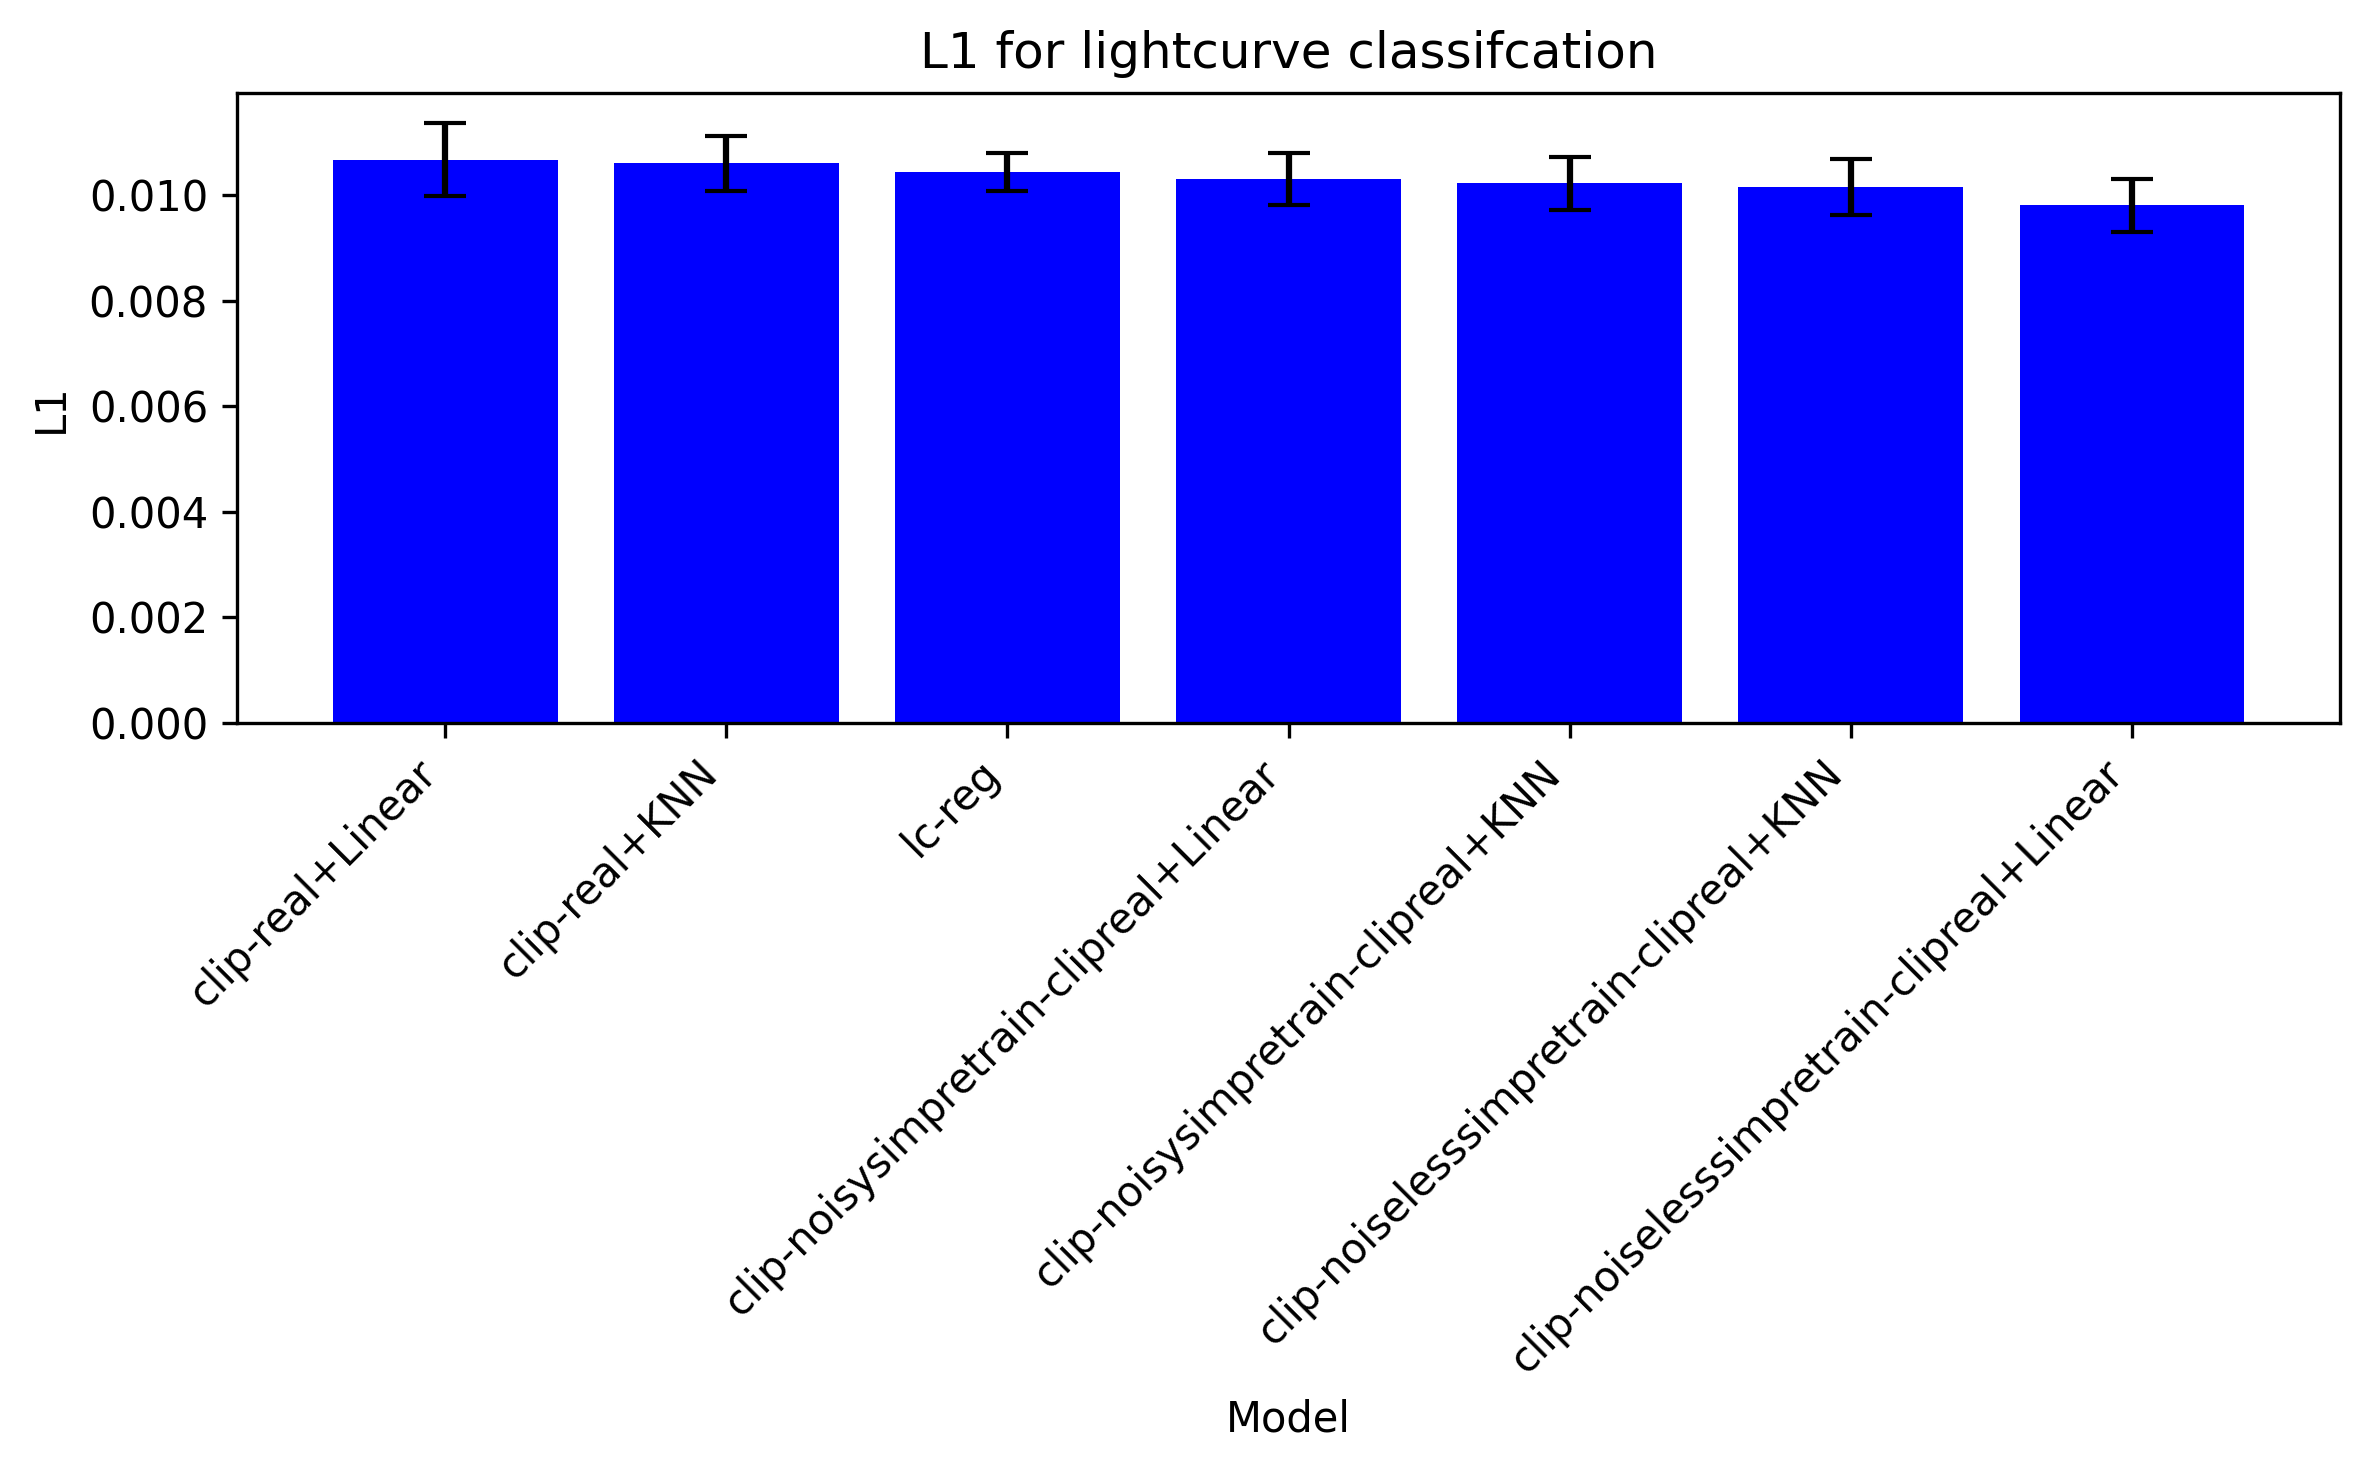

In [125]:
# ========================
variable_name = "L1"  # Choose [ L1	L2	R2	OLF]
modality = "lightcurve"
# ========================

lc_reg_mean = reg_mean[
    reg_mean["Combination"] == modality
]  # .drop(columns=dropcols)
lc_reg_std = reg_std[reg_std["Combination"] == modality]  # .drop(columns=dropcols)
lc_reg_mean = lc_reg_mean.sort_values(by=variable_name, ascending=False)
lc_reg_std = lc_reg_std.loc[lc_reg_mean.index]
plt.figure(figsize=(8, 5), dpi=300)
plt.bar(
    lc_reg_mean["Model"],
    lc_reg_mean[variable_name],
    yerr=lc_reg_std[variable_name],
    capsize=5,
    color="blue",
)
plt.xlabel("Model")
plt.ylabel(variable_name)
plt.title(f"{variable_name} for lightcurve classifcation")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

### Classification results analysis - Analysis of redshift of rightly classified SN

In [126]:
def filter_elements(df, target_class):
    """
    Filters the DataFrame to include only rows where the specified target class is present.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing model predictions and true labels.
    target_class (float): The target class to filter for.

    Returns:
    pd.DataFrame: A DataFrame containing the filtered cases for the specified target class.
    """
    # Ensure the original 'y_pred' is kept intact for reference
    df["y_pred_all"] = df["y_true"]

    # Function to apply the mask within the arrays
    def filter_arrays(row):
        indices_pos_class = [
            i
            for i, (pred, true_label) in enumerate(
                zip(row["y_pred"], row["y_true_label"])
            )
            if pred == target_class and true_label == target_class
        ]
        indices_all = [
            i
            for i, true_label in enumerate(row["y_true_label"])
            if true_label == target_class
        ]
        filtered_lc_data_all = {
            key: [row["lc_data"][key][i] for i in indices_all]
            for key in row["lc_data"]
        } if "lc_data" in row else None
        filtered_lc_data_pos = {
            key: [row["lc_data"][key][i] for i in indices_pos_class]
            for key in row["lc_data"]
        } if "lc_data" in row else None
        
        
        return {
            "y_pred": [row["y_pred"][i] for i in indices_pos_class],
            "y_true": [row["y_true"][i] for i in indices_pos_class],
            "y_true_label": [row["y_true_label"][i] for i in indices_pos_class],
            "y_pred_all": [row["y_pred_all"][i] for i in indices_all],
            "lc_data_all": filtered_lc_data_all,
            "lc_data": filtered_lc_data_pos
        }

    # Apply the function to each row in the DataFrame
    filtered_data = df.apply(filter_arrays, axis=1)

    # Create a new DataFrame from the filtered data
    result_df = pd.DataFrame(filtered_data.tolist(), index=df.index)

    # Handle the lc_data separately to avoid column overlap
    lc_data_filtered = result_df.pop('lc_data')

    # Combine the filtered arrays back with the original DataFrame
    final_df = df.drop(columns=["y_pred", "y_true", "y_true_label", "y_pred_all"]).join(result_df)

    # Add the lc_data back to the final DataFrame
    final_df['lc_data'] = lc_data_filtered

    return final_df.reset_index(drop=True)

Filter out the models you want to compare the redshift distribtion

In [127]:
class_filter = 4.0
remove_models = [
    "three",
    "3way",
    "Linear",
]  
'''
remove_models = [
    "three",
    "3way",
    "Linear",
]  
'''
lc_merged_classification = merged_classification[
    merged_classification["Combination"] == "lightcurve"
]

# Create a regex pattern from the list of strings
pattern = "|".join(remove_models)

if "three" in remove_models:
    class_names = {
        0: ("SLSN-I", "blue"),
        1: ("SN II", "green"),
        2: ("SN IIn", "teal"),
        3: ("SN Ia", "purple"),
        4: ("SN Ibc", "orange"),
    }
else:
    class_names = {
        0: ("SN II", "green"),
        1: ("SN Ia", "purple"),
        2: ("SN Ibc", "orange"),
    }

# Remove rows where the 'Model' column contains any of the strings in remove_models
df_cleaned = lc_merged_classification[
    ~lc_merged_classification["Model"].str.contains(pattern)
].reset_index()
print("We will work with these models: ")
print(df_cleaned[["Model", "Combination"]])
print(f"and we will remove class {class_names[int(class_filter)][0]}")

We will work with these models: 
                                         Model Combination
0  clip-noiselesssimpretrain-clipreal+KNN+five  lightcurve
1      clip-noisysimpretrain-clipreal+KNN+five  lightcurve
2                           clip-real+KNN+five  lightcurve
3                                   lc-5way-f1  lightcurve
and we will remove class SN Ibc


<Figure size 1000x600 with 0 Axes>

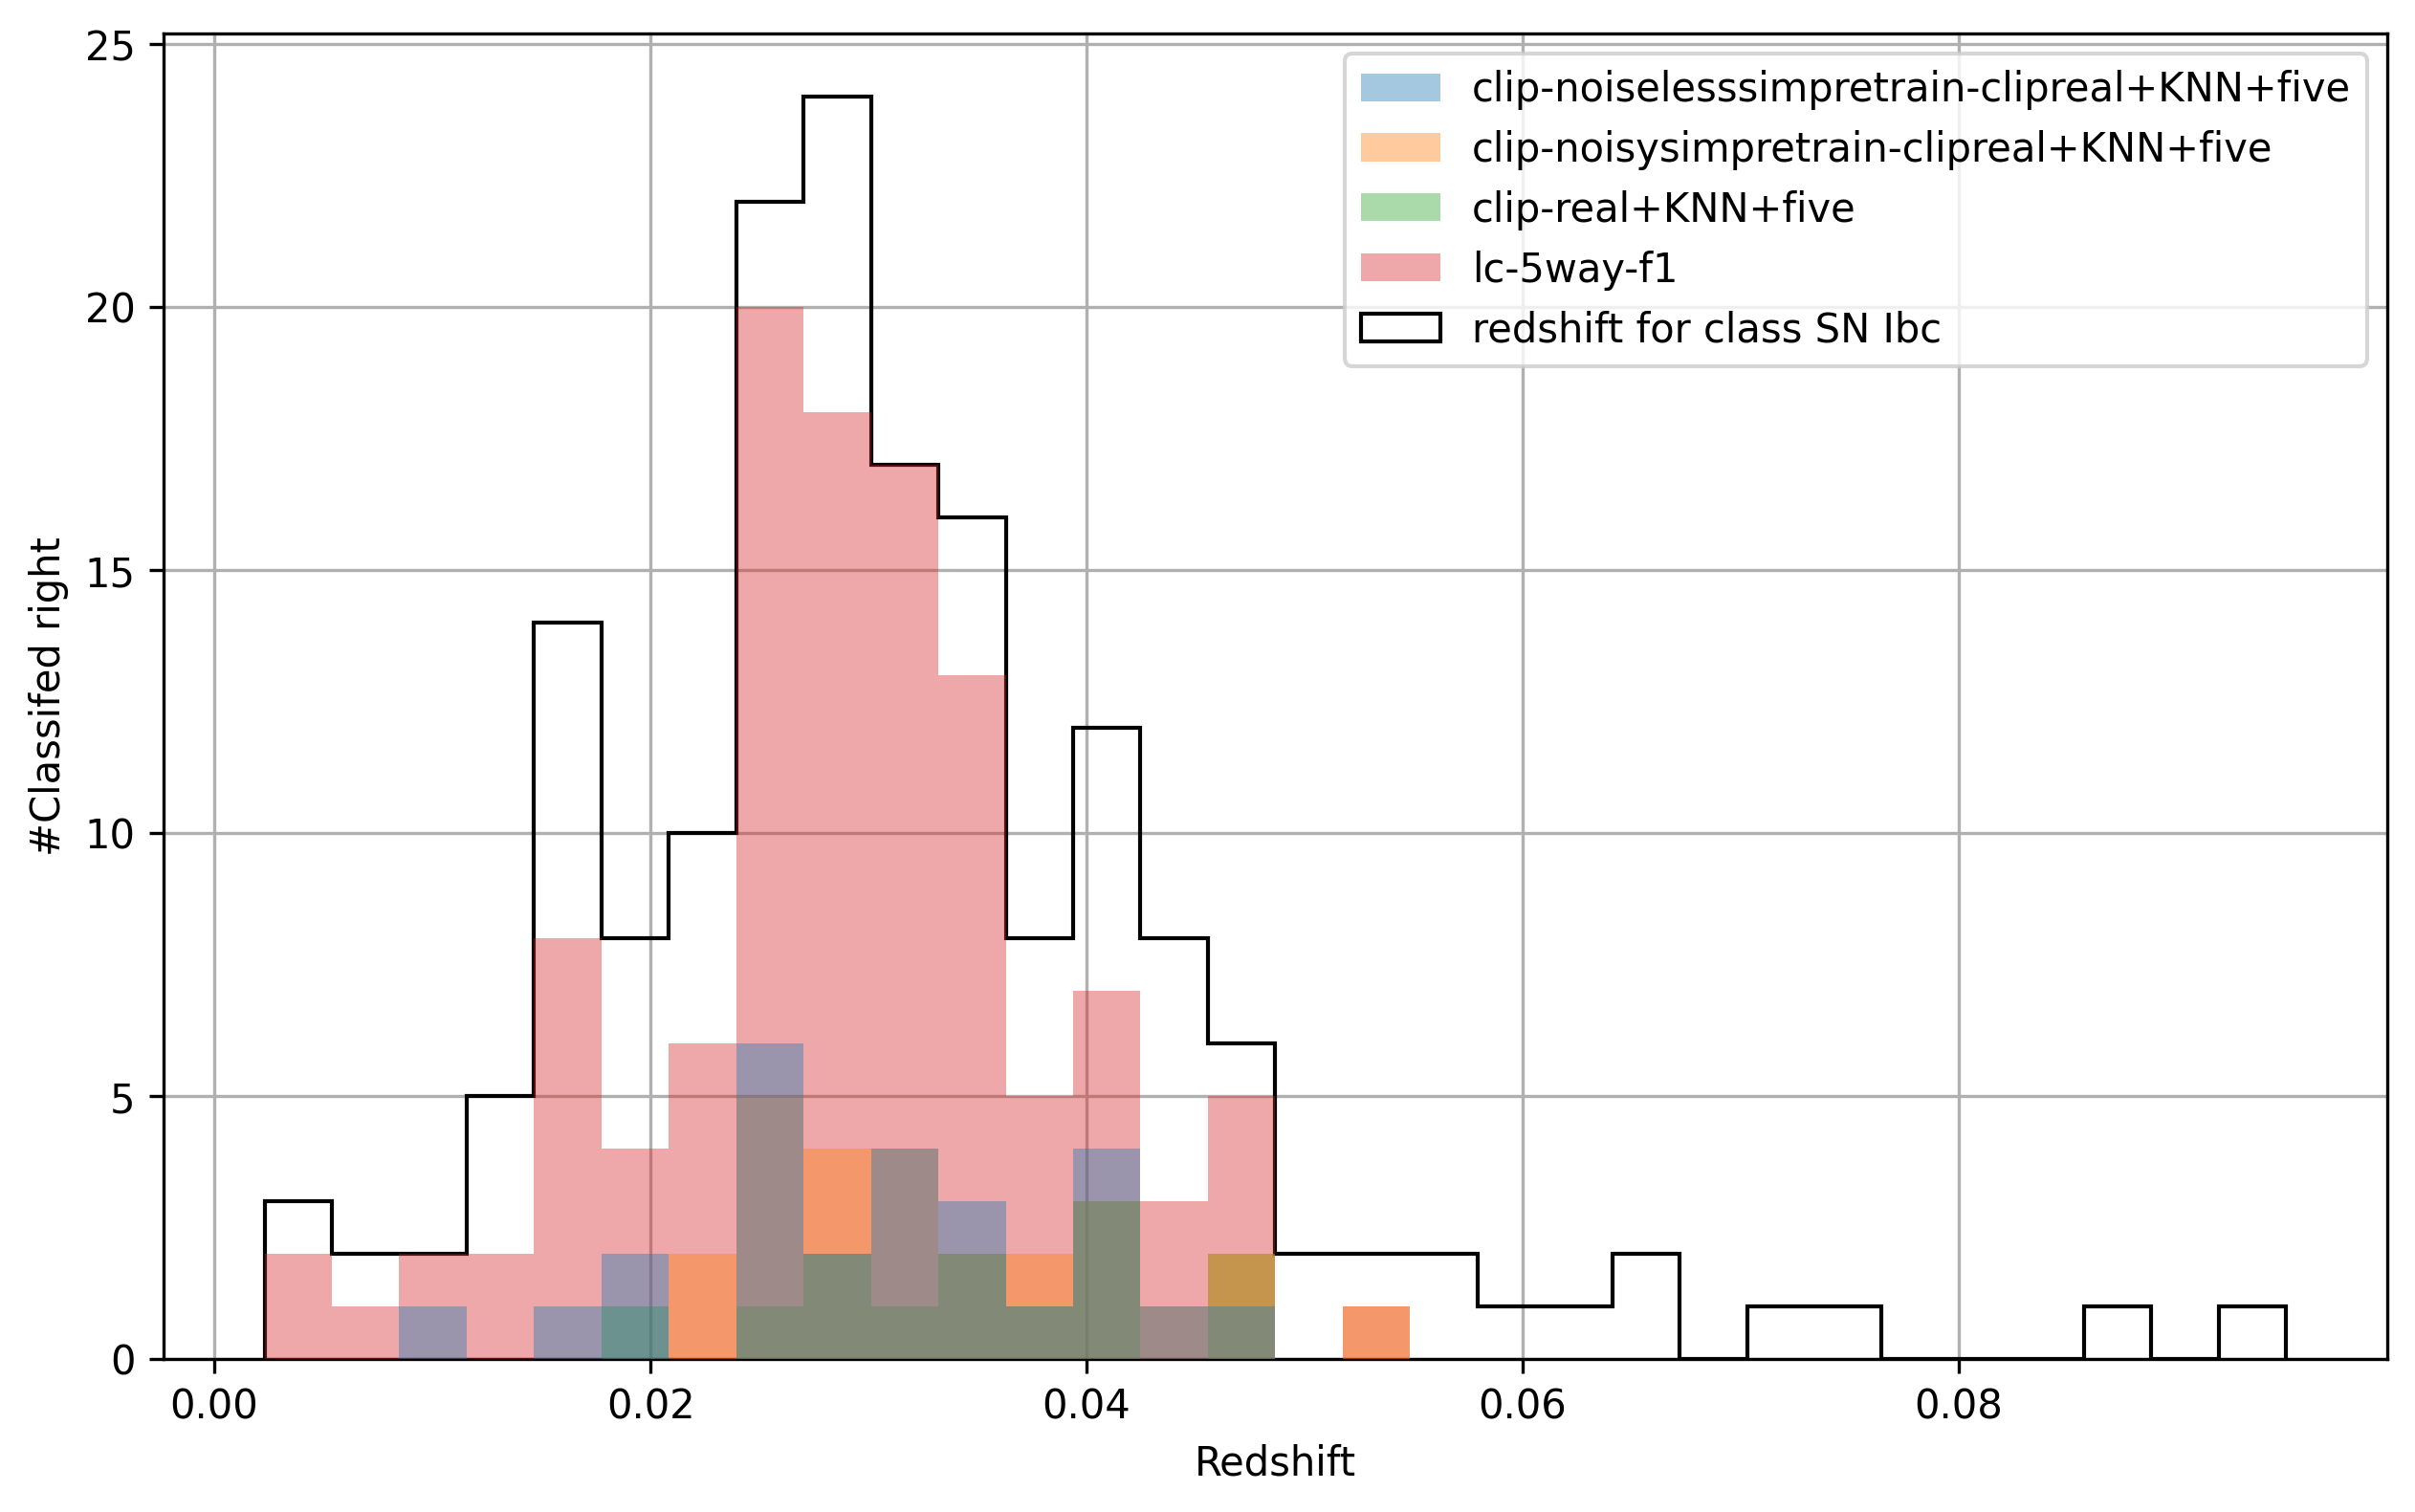

In [143]:
# Filter out classes
filtered_classified = filter_elements(df_cleaned, class_filter)

plt.figure(figsize=(10, 6))

# Determine the number of subplots needed
fig = plt.figure(figsize=(10, 6), dpi=300)
total_class_hist = filtered_classified["y_pred_all"][0]

for i, (index, row) in enumerate(filtered_classified.iterrows()):
    plt.hist(
        row["y_true"],
        bins=30,
        label=row["Model"],
        range=[min(total_class_hist), max(total_class_hist)],
        alpha=0.4,
        zorder = 20 -i
    )
plt.hist(
    total_class_hist,
    color="black",
    edgecolor="black",
    bins=30,
    range=[min(total_class_hist), max(total_class_hist)],
    label=f"redshift for class {class_names[int(class_filter)][0]}",
    histtype="step",
)
plt.xlabel("Redshift")
plt.ylabel("#Classifed right")
plt.legend()
plt.grid(True)

plt.savefig("redshiftmissclass.pdf")
plt.show()

In [144]:
def compute_masked_min(filtered_df, data = 'lc_data'):
    """
    Computes the minimum of x_lc after applying mask_lc for each batch.

    Parameters:
    filtered_df (pd.DataFrame): The filtered DataFrame containing 'lc_data' with 'x_lc' and 'mask_lc'.

    Returns:
    List: A list containing the masked minimum values for each batch.
    """
    x_lc_list = filtered_df[data].apply(lambda d: d['x_lc'] if d is not None else None)
    mask_lc_list = filtered_df[data].apply(lambda d: d['mask_lc'] if d is not None else None)
    masked_min_list = []

    for x_lc, mask_lc in zip(x_lc_list, mask_lc_list):
        if x_lc is not None and len(x_lc) > 0:
            masked_min = np.min(np.where(mask_lc, x_lc, np.inf), axis=1)
            masked_min_list.append(masked_min)
        else:
            masked_min_list.append([])

    return masked_min_list

In [145]:
# Filter out classes
filtered_classified = filter_elements(df_cleaned, class_filter)
min_lc_data_hit = compute_masked_min(filtered_classified,'lc_data')
min_lc_data_class_all = compute_masked_min(filtered_classified,'lc_data_all')

In [146]:
filtered_classified['Model']

0    clip-noiselesssimpretrain-clipreal+KNN+five
1        clip-noisysimpretrain-clipreal+KNN+five
2                             clip-real+KNN+five
3                                     lc-5way-f1
Name: Model, dtype: object

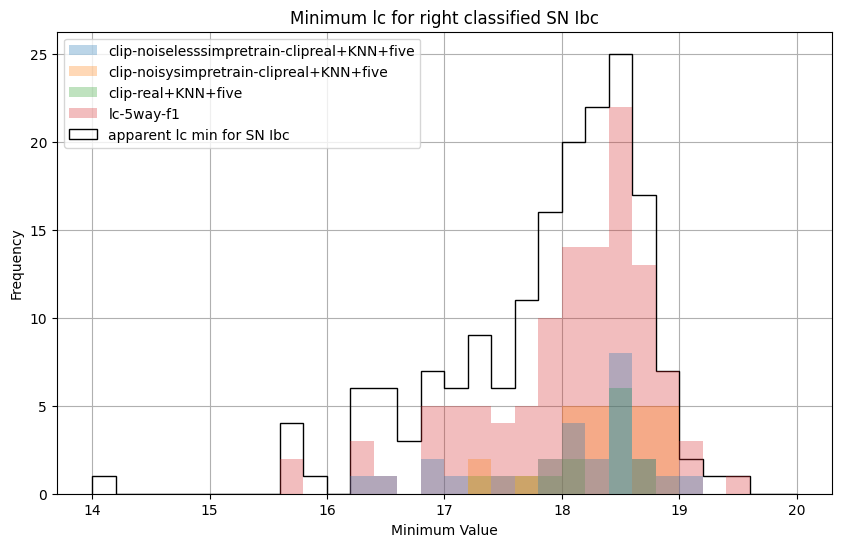

In [148]:
# Plot the masked minimum values
plt.figure(figsize=(10, 6))
for i, data in enumerate(min_lc_data_hit):
    if data is not None:
        plt.hist(data, bins=30, alpha=0.3, label=f'{filtered_classified["Model"][i]}',range = (14,20),zorder = 10-i)

plt.hist(min_lc_data_class_all[0], bins=30, label=f'apparent lc min for {class_names[int(class_filter)][0]}',range = (14,20), histtype="step",edgecolor = 'black')

plt.title(f'Minimum lc for right classified {class_names[int(class_filter)][0]}')
plt.xlabel('Minimum Value')
plt.ylabel('Frequency')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

### Plot confusion plots

In [134]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns


def plot_cm(df_class, modelname, modality, normalisation):
    df_class_filter = df_class[df_class["Model"] == modelname].reset_index()
    df_class_filter = df_class_filter[
        df_class_filter["Combination"] == modality
    ].reset_index()

    if "five" in modelname or "5way" in modelname:
        class_names = {
            0: ("SLSN-I", "blue"),
            1: ("SN II", "green"),
            2: ("SN IIn", "teal"),
            3: ("SN Ia", "purple"),
            4: ("SN Ibc", "orange"),
        }
    else:
        class_names = {
            0: ("SN II", "green"),
            1: ("SN Ia", "purple"),
            2: ("SN Ibc", "orange"),
        }

    cm = confusion_matrix(
        df_class_filter["y_true_label"][0], df_class_filter["y_pred"][0]
    )
    if normalisation == "recall":
        cm = cm.astype("float") / cm.sum(axis=1, keepdims=True)
        formats = ".2f"
    elif normalisation == "precision":
        cm = cm.astype("float") / cm.sum(axis=0, keepdims=True)
        formats = ".2f"
    else:
        formats = "d"

    # Create the plot
    plt.figure(figsize=(5, 4), dpi=100)
    sns.heatmap(
        cm,
        annot=True,
        fmt=formats,
        cmap="Blues",
        xticklabels=[class_names[label][0] for label in sorted(class_names)],
        yticklabels=[class_names[label][0] for label in sorted(class_names)],
    )
    plt.title(
        f'Normalized Confusion Matrix: {df_class_filter["Model"][0]}, {df_class_filter["Combination"][0]}'
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

In [135]:
print(f'available models: \n {merged_classification["Model"]}')

available models: 
 0         clip-noiselesssimpretrain-clipreal+KNN+five
1         clip-noiselesssimpretrain-clipreal+KNN+five
2         clip-noiselesssimpretrain-clipreal+KNN+five
3        clip-noiselesssimpretrain-clipreal+KNN+three
4        clip-noiselesssimpretrain-clipreal+KNN+three
5        clip-noiselesssimpretrain-clipreal+KNN+three
6      clip-noiselesssimpretrain-clipreal+Linear+five
7      clip-noiselesssimpretrain-clipreal+Linear+five
8      clip-noiselesssimpretrain-clipreal+Linear+five
9     clip-noiselesssimpretrain-clipreal+Linear+three
10    clip-noiselesssimpretrain-clipreal+Linear+three
11    clip-noiselesssimpretrain-clipreal+Linear+three
12            clip-noisysimpretrain-clipreal+KNN+five
13            clip-noisysimpretrain-clipreal+KNN+five
14            clip-noisysimpretrain-clipreal+KNN+five
15           clip-noisysimpretrain-clipreal+KNN+three
16           clip-noisysimpretrain-clipreal+KNN+three
17           clip-noisysimpretrain-clipreal+KNN+three
18      

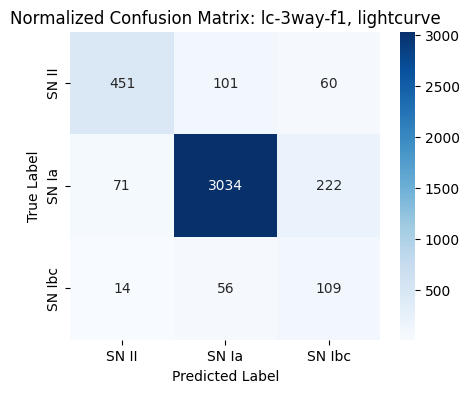

In [136]:
plot_cm(
    merged_classification,
    modelname="lc-3way-f1",
    modality="lightcurve",
    normalisation="NA", # "recall" / "precision"
)